## Introduction

This tutorial will introduce you to some basic methods for preprocessing a raw dataset including data cleaning and feature selection. For a data science project, the dataset plays one of the most important roles. However, in many cases, the raw dataset acquired or collected may not be able to be used directly to train a machine learning model. For example, a dataset can be incomplete (contains N/A) or have some non-numeric features (Mostly are categorical variables) while learning algorithms expect input to be numeric. Therefore, data cleaning always serves as a starting point for a data science project. Besides, even with a cleaned dataset, it can also contain some features that are either redundant or irrelavant, and can thus be removed without incurring much loss of information. Therefore, feature selection is also a very common technique people usually use before they train their machine learning model.

### Tutorial content
In this tutorial, we will show how to do basic data preprocessing and feature selection with Python, specifically using ```Pandas``` and ```Scikit-learn```. ```Seaborn``` and ```Matplotlib``` are used for data visualization. The data we used here contains about 10 years of daily weather observations from many locations across Australia. And the goal of our example is to Predict next-day rain by training classification models on the target variable ***RainTomorrow***.

We will cover the following topics in this tutorial:
* Installing the libraries
* Data inspection
* Data preprocessing
 * reformatting unsupported format
 * handling missing data
 * managing unwanted outliers
 * encoding non-numerical data
* Feature selection
 * Baseline evaluation
 * Filter methods: Remove constant or quasi-constant features
 * Wrapper methods: Recursive feature elimination (RFE)
 * Embeded methods: L1-based feature selection
* Summary

## Installing the libraries
Before we get started, you are supposed to install or upgrade the various libraries we will use in this tutorial. 
You can install all of them using ```pip```:
```
$ pip install pandas --upgrade
```

```
$ pip install seaborn --upgrade
```

```
$ pip install scikit-learn --upgrade
```

```
$ pip install matplotlib --upgrade
```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Glance on the dataset

In [2]:
# Download and load the dataset.
url = "https://raw.githubusercontent.com/maituoy/15688-tutorial/main/weatherAUS.csv"
df = pd.read_csv(url)

In [3]:
# There are 145460 entries and only 2 data types in the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [5]:
# A lot of features contain significant missing data. 
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

## Data Preprocessing

The main steps of data preprocessing including but not limited to ***reformatting unsupported format***, ***handling missing data***, ***managing unwanted outliers***, and ***encoding non-numerical data***. In this tutorial, I will cover all of them with the example dataset. Finally, the output of preprocessing should a clean and well-formatted dataset ready for modeling. 

At the beginning, I would first split the our dataset into features and lable, trainning set and testing set. Since the format of ***RainToday*** and the label ***RainTomorrow*** are both binary categorical object, I preprocess them together for convenience.

In [6]:
# Encode binary labels (RainToday, RainTomorrow) with value 0 (No) and 1 (Yes). 
label_col = df[['RainToday','RainTomorrow']]
le = LabelEncoder()
for col in label_col.columns:
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
df = df.loc[(df['RainToday'] < 2) & (df['RainTomorrow'] < 2)] 

### Step 1: Reformatting unsupported format
As we can see in the inspection of the dataset, the column ***Date*** has an object type and contains deliminator. Therefore, we have to convert it into numeric by splitting the ***Date*** into 3 columns, which are ***year***, ***month***, and ***date***, respectively.

In [7]:
# Split the Date into 3 columns with each contains year, month, and date. 
# Drop the original Date column.
df[['year','month','date']] = df['Date'].str.split('-',expand=True)
df.drop(['Date'], axis=1, inplace=True)
df['year'] = df['month'].astype(int)
df['month'] = df['month'].astype(int)
df['date'] = df['date'].astype(int)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140787 entries, 0 to 145458
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       140787 non-null  object 
 1   MinTemp        140319 non-null  float64
 2   MaxTemp        140480 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   Evaporation    81093 non-null   float64
 5   Sunshine       73982 non-null   float64
 6   WindGustDir    131624 non-null  object 
 7   WindGustSpeed  131682 non-null  float64
 8   WindDir9am     131127 non-null  object 
 9   WindDir3pm     137117 non-null  object 
 10  WindSpeed9am   139732 non-null  float64
 11  WindSpeed3pm   138256 non-null  float64
 12  Humidity9am    139270 non-null  float64
 13  Humidity3pm    137286 non-null  float64
 14  Pressure9am    127044 non-null  float64
 15  Pressure3pm    127018 non-null  float64
 16  Cloud9am       88162 non-null   float64
 17  Cloud3pm       84693 non-null

### Step 2: Handling missing data
In this step, we are going to handle the missing data. However, since we have different strategies in dealing with the missing data for numerical features and categorical features, we are going to split our dataset into ***numerical*** dataset (The columns with dtype = float64 or int64) and ***categorical*** dataset (The columns with dtype = object). We will fill the null data in numerical set with the median value of that feature and fill the null data in the categorical set with the most frequent value occurs in the column.

In [9]:
# Split the df into numerical and categorical with the df.select_dtypes() function in pandas.
numerical = df.select_dtypes(include=['float64','int64'])
categorical = df.select_dtypes(include='object')

Now, we will start with handling the missing data in the numerical dataset. First, let's inspect how many missing data are there in the numerical.

In [10]:
missing_percent = (numerical.isna().sum()/len(numerical)).sort_values()
missing_percent

date             0.000000
Rainfall         0.000000
year             0.000000
RainTomorrow     0.000000
RainToday        0.000000
month            0.000000
MaxTemp          0.002181
MinTemp          0.003324
Temp9am          0.004660
WindSpeed9am     0.007494
Humidity9am      0.010775
WindSpeed3pm     0.017978
Temp3pm          0.018638
Humidity3pm      0.024867
WindGustSpeed    0.064672
Pressure9am      0.097616
Pressure3pm      0.097800
Cloud9am         0.373792
Cloud3pm         0.398432
Evaporation      0.424002
Sunshine         0.474511
dtype: float64

As we can see above, we have 15 features that contain missing data and the most incomplete feature ***Sunshine*** has almost half of its values missed. We are going to use a very useful tool ***sklearn.impute.SimpleImputer*** to help us fill the null data.

In [11]:
# We can also use the SimpleImputer to replace values in the dataset with 
# specific value by specifying the argument strategy = 'constant' and fill_value = TARGET.
si = SimpleImputer(strategy='median')
numerical = pd.DataFrame(data=si.fit_transform(numerical), columns=numerical.columns)
numerical.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
year             0
month            0
date             0
dtype: int64

Now, it looks better, there is no numerical feature containing the null data. In the next step, we are going to replace all null data in categorical feature with their most frequent value.

In [12]:
# There are only three features in the categorical set have missing data.
categorical.isna().sum() 

Location          0
WindGustDir    9163
WindDir9am     9660
WindDir3pm     3670
dtype: int64

In [13]:
for feat in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    most_frequent = categorical[feat].mode()[0]
    si_cate = SimpleImputer(strategy='constant', fill_value=most_frequent)
    categorical[feat] = si_cate.fit_transform(categorical[feat].to_frame())

<ipython-input-13-be8f750bf938>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical[feat] = si_cate.fit_transform(categorical[feat].to_frame())
<ipython-input-13-be8f750bf938>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical[feat] = si_cate.fit_transform(categorical[feat].to_frame())
<ipython-input-13-be8f750bf938>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [14]:
# Now, it's all non-null.
categorical.isna().sum() 

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
dtype: int64

### Step 3: Managing unwanted outliers
Many training data contains outlier which are usually be defined as the data point far from others. Let's first take a look at the boxplot of numerical dataset and see which features have the most outliers. 

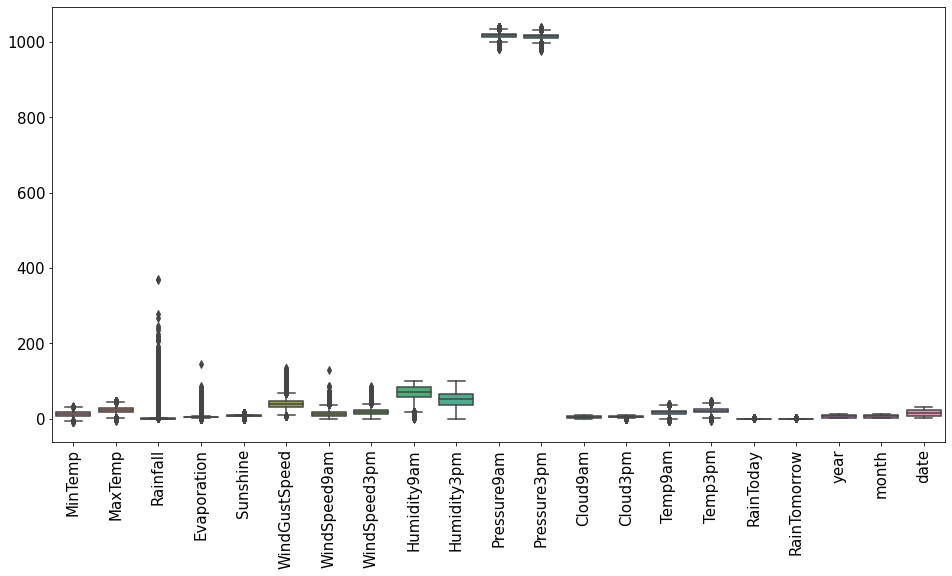

In [15]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(data=numerical)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.show()

From the above boxplot, we can see there are 5 features have the most outliers among the others. They are ***Rainfall***, ***Evaporation***, ***WindGustSpeed***, ***WindSpeed9am***, and ***WindSpeed3pm***. What we are going to do is to cap the lower and upper bound of those features. The interquartile range (IQR) is usually used to determine the lower and upper bound.

In [16]:
# Calculate the lower and upper bound of each feature with too many outliers.
bound_dict = {}
# Rainfall
for feat in ['Rainfall','Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    q1 = numerical[feat].quantile(.25)
    q3 = numerical[feat].quantile(.75)
    maximum = q3 + 3*(q3-q1)
    minimum = q1 - 3*(q3-q1)
    bound_dict[feat] = (minimum, maximum)

In [17]:
# Replace the values above the upper bound by the maximum value 
# and the values below the lower bound by the minimum value.
for feat in ['Rainfall','Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    max_value = bound_dict[feat][1]
    min_value = bound_dict[feat][0]
    numerical[feat] = numerical[feat].apply(lambda x: max_value if x > max_value else min_value if x < min_value else x)

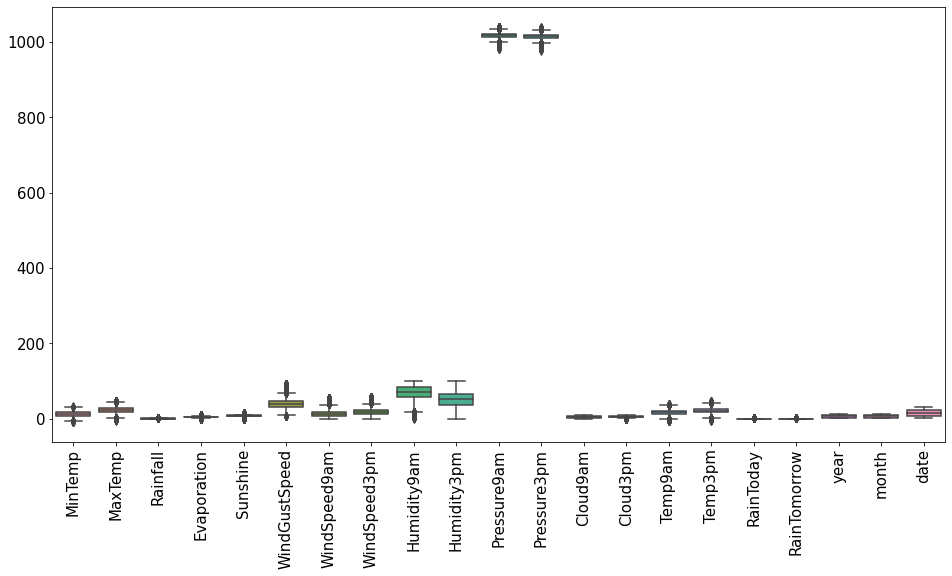

In [18]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(data=numerical)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Let's visualize the boxplot again, now you can see all numerical data becomes clean and nice.

### Step 4: Encoding non-numerical data
In the last step, we would like to convert all categorical data into numerical because the machine can not understand the categories until we express them in a numerical way. The most widespread method for conversion is using the one-hot encoding which creates new columns, indicating the presence of each possible value from the original data. In this tutorial, we are going to use the pd.get_dummies() to do this work.

In [19]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140787 entries, 0 to 145458
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Location     140787 non-null  object
 1   WindGustDir  140787 non-null  object
 2   WindDir9am   140787 non-null  object
 3   WindDir3pm   140787 non-null  object
dtypes: object(4)
memory usage: 5.4+ MB


In [20]:
# One-hot encode these categorical features using the 
# pd.get_dummies()
categorical = pd.get_dummies(data=categorical)


Now let's deal with the numerical features. First of all, we will replace all null data with the mean value of that feature. Then, we would like to perform some scaling on all numerical features. Applying a scaling to the data does not change the shape of each feature's distribution. However, normalization ensures that each feature is treated equally when the model is trained.

In [21]:
categorical

,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
145457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [22]:
numerical

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,date
0,13.4,22.9,0.6,4.8,8.5,44.0,20.0,24.0,71.0,22.0,...,1007.1,8.0,5.0,16.9,21.8,0.0,0.0,12.0,12.0,1.0
1,7.4,25.1,0.0,4.8,8.5,44.0,4.0,22.0,44.0,25.0,...,1007.8,5.0,5.0,17.2,24.3,0.0,0.0,12.0,12.0,2.0
2,12.9,25.7,0.0,4.8,8.5,46.0,19.0,26.0,38.0,30.0,...,1008.7,5.0,2.0,21.0,23.2,0.0,0.0,12.0,12.0,3.0
3,9.2,28.0,0.0,4.8,8.5,24.0,11.0,9.0,45.0,16.0,...,1012.8,5.0,5.0,18.1,26.5,0.0,0.0,12.0,12.0,4.0
4,17.5,32.3,1.0,4.8,8.5,41.0,7.0,20.0,82.0,33.0,...,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,12.0,12.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140782,3.5,21.8,0.0,4.8,8.5,31.0,15.0,13.0,59.0,27.0,...,1021.2,5.0,5.0,9.4,20.9,0.0,0.0,6.0,6.0,20.0
140783,2.8,23.4,0.0,4.8,8.5,31.0,13.0,11.0,51.0,24.0,...,1020.3,5.0,5.0,10.1,22.4,0.0,0.0,6.0,6.0,21.0
140784,3.6,25.3,0.0,4.8,8.5,22.0,13.0,9.0,56.0,21.0,...,1019.1,5.0,5.0,10.9,24.5,0.0,0.0,6.0,6.0,22.0
140785,5.4,26.9,0.0,4.8,8.5,37.0,9.0,9.0,53.0,24.0,...,1016.8,5.0,5.0,12.5,26.1,0.0,0.0,6.0,6.0,23.0


At last, we have to merge the numerical dataset with the categorical dataset and split the label and the features.

In [23]:
df_new = pd.concat([numerical, categorical], axis=1, join='inner')
X = df_new.drop(['RainTomorrow'], axis=1)
y = df_new['RainTomorrow']

In [24]:
# Normalize the X using the MinMaxScaler

scaler = MinMaxScaler()

X = scaler.fit_transform(X)

## Feature selection
Feature selection is the process that you manully or automatically select a subset of features which can contains most informations of your dataset. Feature selection techniques are commonly used because of many advantages:

* Reduce the dimensionality of your dataset.
* Shorten the training time.
* Increase the accuracy by eliminating the noisy data.
* Avoid overfitting.

Currently, there are three main categories of feature selection techniques: ***filter methods***, ***wrapper methods***, and ***embeded methods***. Due to the length limit of this tutorial, I will only cover one technique for each category.

### Baseline evaluation
Before we get started, I would first evaluate the baseline of the whole dataset and see how it works even without any feature selections. I use the logistic regression classifier and the liblinear as the solver. And the accuracy_score is used as the metrics to evaluate the performance of the model.
#### Logistic regression classifier

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# instantiate the model
clf = LogisticRegression(solver='liblinear', random_state=0)

# fit the model
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
print('Model accuracy score: {0:0.4f}'. format(clf.score(X_test, y_test)))

Model accuracy score: 0.8477


### Filter methods: Remove constant or quasi-constant features
The simplest feature selection technique is removing the features with zero variance or very small variance. For those features, they have the same (or almost the same) values in all samples which might not able to provide any useful information to the model. ```VarianceThreshold(threshold)``` is an approach from ```sklearn.feature_selection``` model that will remove the features with a training-set variance lower than the preset threshold.

In [27]:
# The threshold is preset to 0.02 which mean the features with a variance lower than 0.02 will be removed.
sel = VarianceThreshold(0.02)
selected_features = sel.fit_transform(X)
selected_features.shape

(136224, 104)

Our dataset originally has 117 features. After the filteration of ```VarianceThreshold()```, we got 104 features remained.

In [28]:
# With the filtered features, we rebuild our model. 
X_train, X_test, y_train, y_test = train_test_split(selected_features, y, test_size=0.3, random_state=0)
clf = LogisticRegression(solver='liblinear', random_state=0)

In [29]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
print('Model accuracy score after filteration : {0:0.4f}'. format(clf.score(X_test, y_test)))

Model accuracy score after filteration : 0.8427


### Wrapper methods: Recursive feature elimination (RFE) 
The wrapper methods incorperates a machine leaning algorithm and uses performance as evaluation criteria. This method is able to find the optimal feature subset for the selected machine learning algorithm. However, this method has its disadvantages. For example, when the number of features is large, the computational time can be significant. RFE is one of the wrapper methods that can prune the least important features from the current set of features recursively until desired number of features are selected.

#### RFE with cross-validation

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

clf = LogisticRegression(solver='liblinear', random_state=0)

# Minimum number of features to consider
min_features_to_select = 1 

# instantiate the RFE cross validation model
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(2),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)

In [32]:
rfecv.fit(X,y)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=0,
                                   solver='liblinear', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [33]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 23


Using the RFE with cross-validation, we are able to obtain the optimal number of features for logistic regression is 23. As shown in the figure below, the validation score reaches the highest at this number.

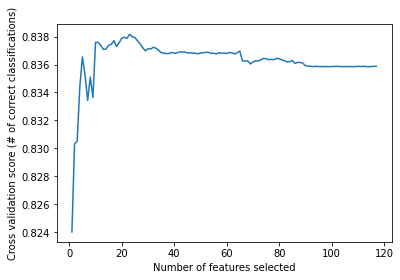

In [34]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (# of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

With the reduced dataset, we build a new logistic regression model and find the accuracy score is comparable to what we get with the full dataset. However, in this way, we are able to reduce the number of features from 117 to 23. In another word, we have successfully simplified the dataset without sacrificing the performance of the model.

In [35]:
X_sel = rfecv.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=0)

In [36]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
clf.score(X_test, y_test)

0.8470178014314553

### Embeded methods: L1-based feature selection
Embedded methods are methods that can take care of each iteration of the model training process and extract the most important features in each iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold. In this tutorial, we would like to introduce the L1-based feature selection implemented by the ```SelectFromModel``` and estimated by the ```LinearSVC```. 

In [38]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Build the model with SelectFromModel.
sel = SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False, tol=0.01).fit(X, y), prefit=True)


In [39]:
# Transform the dataset based on the selected features.
X_sel = sel.transform(X)

With this method, we are able to reduce the size of our input feature set from 117 to 70.

In [40]:
X_sel.shape

(136224, 71)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=0)

In [42]:
clf = LogisticRegression(solver='liblinear', random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
clf.score(X_test, y_test)

0.847751881079097

As the same as the wrapper method, the embeded method also achieves a comparable accuracy score with a reduced dataset.

## Summary and references
This tutorial introduces some basic methods for data preprocessing and feature selection. Based on the dataset we used, the feature selection methods are not able to improve the performance of predicting. However, it may significantly decrease training time by reducing the size of dataset. I do believe this situation is not common and it's dataset dependent. More details about the data preprocessing and feature selection are available from the following links.

1. Feature selection:
    * https://scikit-learn.org/stable/modules/feature_selection.html
    * https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection#2.-Filter-Methods-
    * https://www.datacamp.com/community/tutorials/feature-selection-python
2. Data preprocessing
    * https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
    * https://www.geeksforgeeks.org/data-cleansing-introduction/
